### Part 4: Retention analysis. Churn rate

Before we calculate, vizualize and compare retention rate across different user groups, let's first see weekly:
  - how many users are new, how many users been in the feed both current and last week, how many users been active last, but not current week? 
  
So the groups are:

  - new users: start their activity of the current week
  - retained users: active both of the current and previous weeks
  - gone users: been active on previous week, but not on the current week

In [1]:
# start with the imports we would need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from scipy.stats import chi2_contingency # Chi-Squared testing
import pandas as pd
import pandahouse as ph # Connect with clickhouse DB
import seaborn as sns


In [35]:
# set quality of the plots to be built
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Set the scaling factors for the plots
SCALE = 1 / 6
sns.set(font_scale=1 * SCALE)


In [36]:
# set the connection with the db
CONNECTION = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }


In [37]:
# get a table where for each week we count:
# 1. new users;
# 2. users active this and previous week;
# 3. users active this, but not following week.
query = '''
-- table where for every unique pair user-active week, 
-- shows if this user joined that week, was active last week, and was active next week
WITH weeks_labeled AS (
SELECT 
user_id, 
week, 
all_weeks,
start_week,
if(has(all_weeks, week - 7), 1, 0) AS is_previous_week,
if(has(all_weeks, week + 7), 1, 0) AS is_next_week

FROM

-- table showing all user activity weeks aggregated into an array
(SELECT DISTINCT user_id, 
toStartOfWeek(time) AS week, 
groupUniqArray(toStartOfWeek(time)) OVER (PARTITION BY user_id) AS all_weeks,
min(toStartOfWeek(time)) OVER (PARTITION BY user_id) AS start_week
FROM simulator_20230720.feed_actions) t1
)

SELECT toString(week) as week,
new_users,
retained_users,
gone_users

FROM 
-- table having counts for new and retained users by week
(SELECT 
week, 
countIf(week = start_week) AS new_users,
countIf(is_previous_week = 1) AS retained_users
FROM weeks_labeled
GROUP BY week
) with_retained

JOIN 

-- table having counts for users who didn`t come from last week.
-- basically, weeks are shifted one week up to align 
-- with is_next_week column to indicate how many users did not come ("gone")
(SELECT 
week + 7 AS to_next_week,
countIf(is_next_week = 0) * (-1) AS gone_users
FROM weeks_labeled
GROUP BY to_next_week
) with_gone

ON (with_retained.week = with_gone.to_next_week)
'''

# import a table to a dataframe
weeks_by_user_groups = ph.read_clickhouse(
    query, 
    connection=CONNECTION
)


In [38]:
# set the index - this simplifies plotting of the bar plot
weeks_by_user_groups.set_index('week', inplace=True)


In [39]:
weeks_by_user_groups.info()
weeks_by_user_groups.head(5)


<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 2023-06-04 to 2023-07-23
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   new_users       8 non-null      uint64
 1   retained_users  8 non-null      uint64
 2   gone_users      8 non-null      int64 
dtypes: int64(1), uint64(2)
memory usage: 256.0+ bytes


,new_users,retained_users,gone_users
week,,,
2023-06-04,11592,853,-25
2023-06-11,13438,11215,-1230
2023-06-18,14061,20281,-4393
2023-06-25,14861,26847,-8357
2023-07-02,13202,32189,-12208


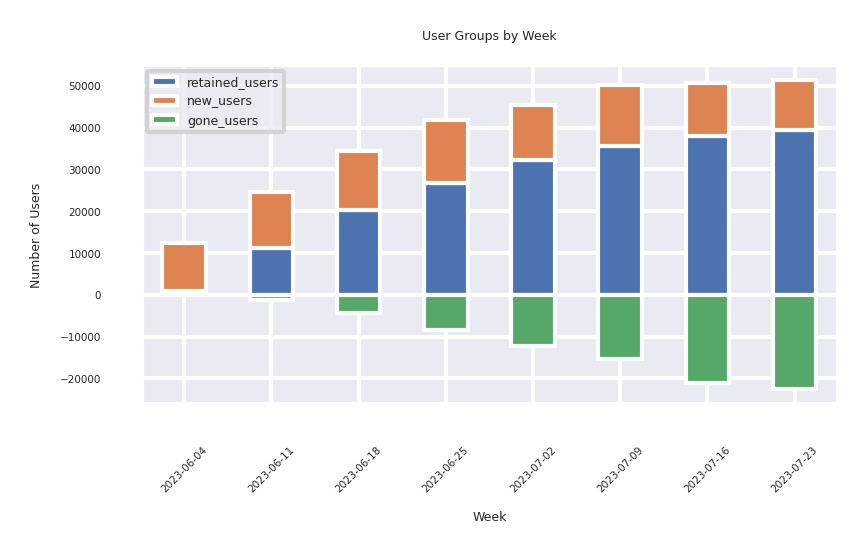

In [40]:
# make a canvas, set sizes
fig, ax = plt.subplots(figsize=(18 * SCALE, 9 * SCALE))
fontsize=18 * SCALE
labelsize=15 * SCALE

# create a bar plot
weeks_by_user_groups[['retained_users','new_users','gone_users']].plot.bar(ax=ax, stacked=True, rot=0)

# adjust fonts and ticks
ax.set_xlabel('Week', fontsize=fontsize)
ax.set_ylabel('Number of Users', fontsize=fontsize)
ax.set_title('User Groups by Week', fontsize=fontsize)

ax.tick_params(axis='y', labelsize=labelsize)
ax.tick_params(axis='x', rotation=45, labelsize=labelsize)

ax.legend(fontsize=fontsize)

plt.show()


As we can see, the incoming users level stays almost constant at 10-15 000 users per week.  
Retained users (our most stable ones) are growing in the beginning and slow down the growth at about 40 000 per week.  
Leaving users are still growing though, reaching 20 000 users per week at a peak.

Let's look at these groups in more detail: does retention pattern differ between users who came to the feed via different sources?

#### Problem 1. Retention pattern of ads- VS organic-sourced users

In our news feed usage data, there are two types of users: those who came through paid traffic with the source 'ads', and those who came through "organic" channels with the source 'organic'.

Our goal is to analyze and compare the retention of these two groups. We should answer the question: **does the usage behavior of the app differ between these groups of users?**

#### Questions

1. How does retention look for these two groups?
2. Is retention different between these two groups?
3. Is retention rate different?
4. (extra) Are these groups otherwise similar in age, gender?
5. (extra) Survival rate analysis.

#### Steps to do

1. a. get a table: 
  - start_day: day of start using the feed, 
  - day: day, 
  - ads_users: amount of unique users who came via ads and started using the product on start_day and use it on the day = day,
  - organic_users: same but organic users,
  - ads_users_percentage: metrics normalized to the amount of the users at the start_day,
  - organic_users_percentage: same,
  - organic_users_percentage - ads_users_percentage: difference between two percentages.
  
1. b. get a table: 
   - user_id,
   - start_day,
   - active_days: number of active days for the user,
   - last_date: day of the last activity,
   - os,
   - gender,
   - age_group,
   - source.  
   
2. Plot Retention over time (heatmaps) for these two groups - do visual comparison
3. Plor heatmap of organic_users_percentage - ads_users_percentage
4. Choose a starting day and period to perform Chi-square test of retention rate for the groups
5. a/a test for other metrics?
6. survival rate like in habr article?

In [41]:
# first, query a dataframe where number of active users by source group is aggregated
# across the day and the starting day of the users
query = '''
WITH retained_users AS (
SELECT *
   FROM
     (SELECT user_id,
             min(toDate(time)) AS start_day
      FROM {db}.feed_actions
      GROUP BY user_id) t1
   JOIN
     (SELECT DISTINCT user_id,
                      gender,
                       multiIf(age <= 16, '0-15', age > 16 and age <= 30, '16-30', age > 30 and age <= 55, '30-55', '55+') AS age_group,
                       os,
                       source,
                      toDate(time) AS day
      FROM {db}.feed_actions) t2 USING user_id
   WHERE (start_day BETWEEN '2023-07-02'::DATE AND '2023-07-20'::DATE) AND (day != today())
),

retained_users_by_date_source AS (

SELECT toString(start_day) start_day,
       toString(day) day,
                     countIf(user_id, source = 'ads') AS users_ads,
                     countIf(user_id, source = 'organic') AS users_organic,
                     count(user_id) AS users
FROM retained_users
GROUP BY start_day,
         day
)

SELECT start_day,
day,
users_ads,
MAX(users_ads) OVER (PARTITION BY start_day) AS users_ads_start,
users_organic,
MAX(users_organic) OVER (PARTITION BY start_day) AS users_organic_start
FROM retained_users_by_date_source
'''

# import the table to a dataframe; convert number of user to float
# to calculate percentage of users relative to their start day
# at the next steps
users_by_day_source = ph.read_clickhouse(
    query, 
    connection=CONNECTION
).astype(
    dtype={'users_ads_start': 'float', 'users_organic_start': 'float'}
) 


In [42]:
users_by_day_source.info()
users_by_day_source.head(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   start_day            342 non-null    object 
 1   day                  342 non-null    object 
 2   users_ads            342 non-null    uint64 
 3   users_ads_start      342 non-null    float64
 4   users_organic        342 non-null    uint64 
 5   users_organic_start  342 non-null    float64
dtypes: float64(2), object(2), uint64(2)
memory usage: 16.2+ KB


,start_day,day,users_ads,users_ads_start,users_organic,users_organic_start
0,2023-07-02,2023-07-18,168,1247.0,213,1076.0
1,2023-07-02,2023-07-26,125,1247.0,160,1076.0


In [43]:
# set new columns with percentages  - divide the amount of users by the amount at their starting day
users_by_day_source['retained_percentage_ads'] = users_by_day_source['users_ads'].div(users_by_day_source['users_ads_start']).mul(100)
users_by_day_source['retained_percentage_organic'] = users_by_day_source['users_organic'].div(users_by_day_source['users_organic_start']).mul(100)

users_by_day_source.head(2)

,start_day,day,users_ads,users_ads_start,users_organic,users_organic_start,retained_percentage_ads,retained_percentage_organic
0,2023-07-02,2023-07-18,168,1247.0,213,1076.0,13.472334,19.795539
1,2023-07-02,2023-07-26,125,1247.0,160,1076.0,10.024058,14.869888


In [44]:
# Create a function that plots a retention heatmap on a given grid
def heatmapper(
    table: pd.DataFrame, 
    ax: axes._axes.Axes,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None,
    SCALE: int = 1 / 6,
    ) -> None:
    """
    Plots a heatmap for the given pivot table (table) on the given axis (ax)
    """
    
    # Check the label values and infer those not set from the table:
    if not ylabel:
        ylabel = table.columns.name
    if not xlabel:
        xlabel = table.index.name
    if not title:
        title = f"{ylabel} vs {xlabel}"
        
    # Plot the heatmap of the retention of ad-sourced users
    sns.heatmap(table, annot=True, cmap='coolwarm', fmt='.0f', cbar=False, ax=ax)
    ax.set_title(title, fontsize=18 * SCALE)
    ax.set_xlabel(xlabel, fontsize=18 * SCALE)
    ax.set_ylabel(ylabel, fontsize=18 * SCALE)
    
    # now move X axis tick labels closer to the X axis:
    # Get the current tick labels
    tick_labels = ax.get_xticklabels()

    # Set the padding/offset for the tick labels (adjust this value as needed)
    padding = 0.5 * SCALE
    for label in tick_labels:
        label.set_y(label.get_position()[1] + padding)

    # Create new tick labels with right alignment
    new_tick_labels = [label.get_text().ljust(25) for label in tick_labels]

    # Set the new tick labels
    ax.set_xticklabels(new_tick_labels)
    ax.tick_params(axis='x', rotation=45, labelsize=18 * SCALE)
    ax.tick_params(axis='y', rotation=0, labelsize=18 * SCALE)

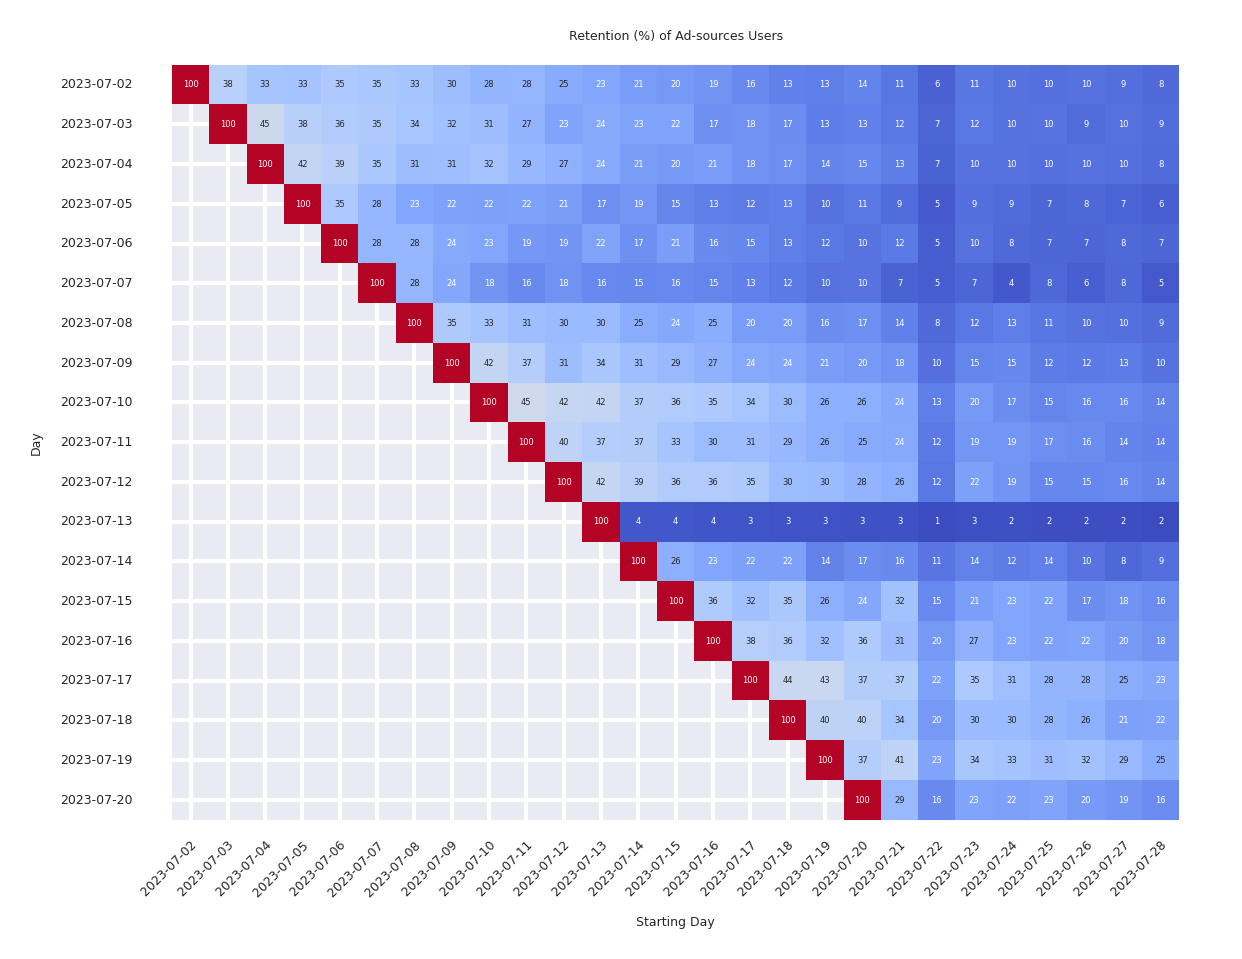

In [45]:
# now, get a heatmap for ads-sourced users

# Get a canvas for the plot
fig, ax = plt.subplots(figsize=(26 * SCALE, 20 * SCALE))

# Create a pivot table to reshape the data
pivot_table_ads = users_by_day_source.pivot_table(index='start_day', columns='day', values='retained_percentage_ads')

# Plot the map
heatmapper(
    pivot_table_ads, 
   ax=ax, 
   title='Retention (%) of Ad-sources Users', 
   xlabel='Starting Day',
   ylabel='Day',
   SCALE = SCALE
)


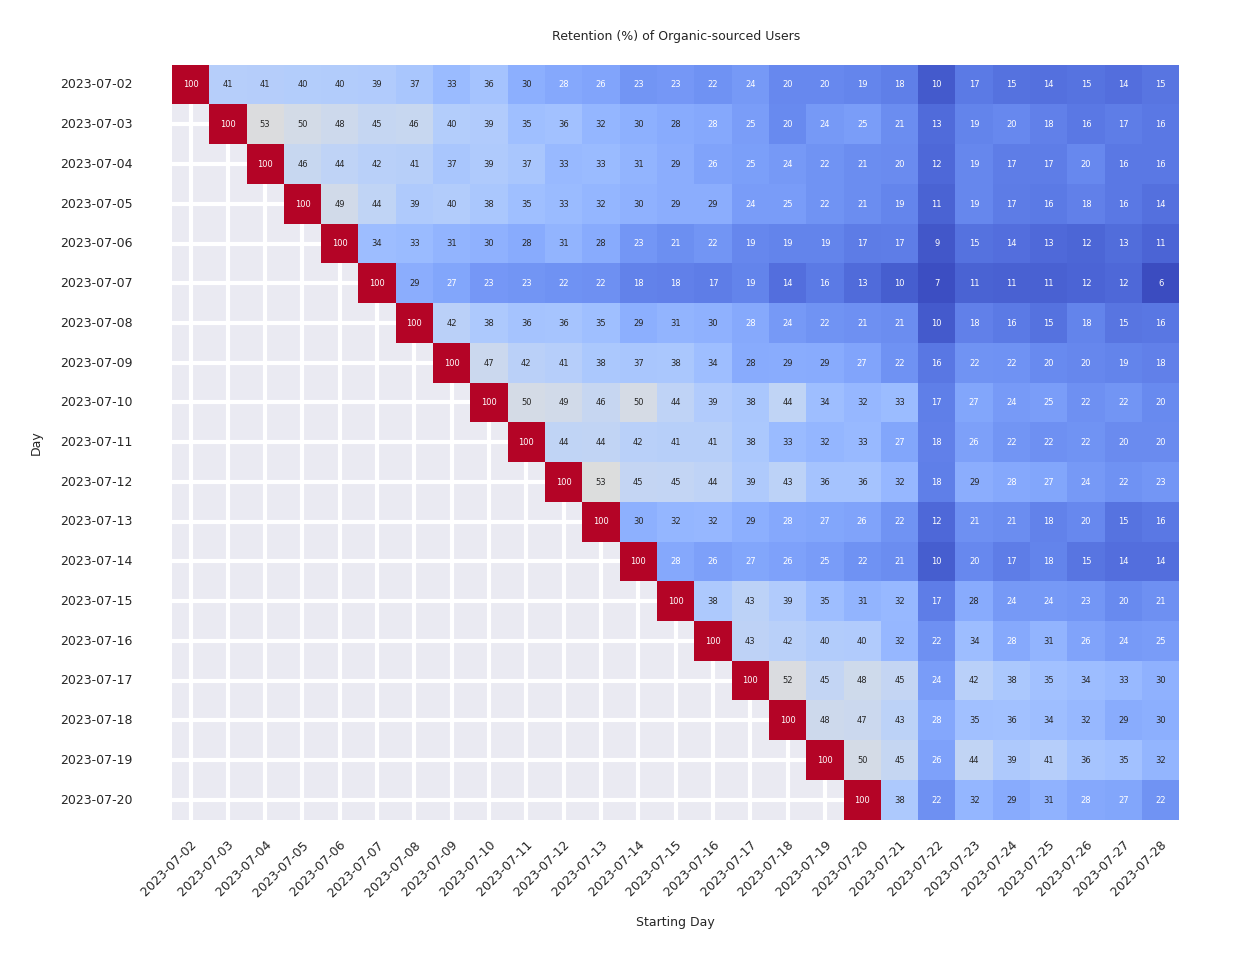

In [46]:
# now the same for organic users

# Get a canvas for the plot
fig, ax = plt.subplots(figsize=(26 * SCALE, 20 * SCALE))

# Create a pivot table to reshape the data
pivot_table_organic = users_by_day_source.pivot_table(index='start_day', columns='day', values='retained_percentage_organic')

# Plot the map
heatmapper(
    pivot_table_organic, 
   ax=ax, 
   title='Retention (%) of Organic-sourced Users', 
   xlabel='Starting Day',
   ylabel='Day',
   SCALE = SCALE
)


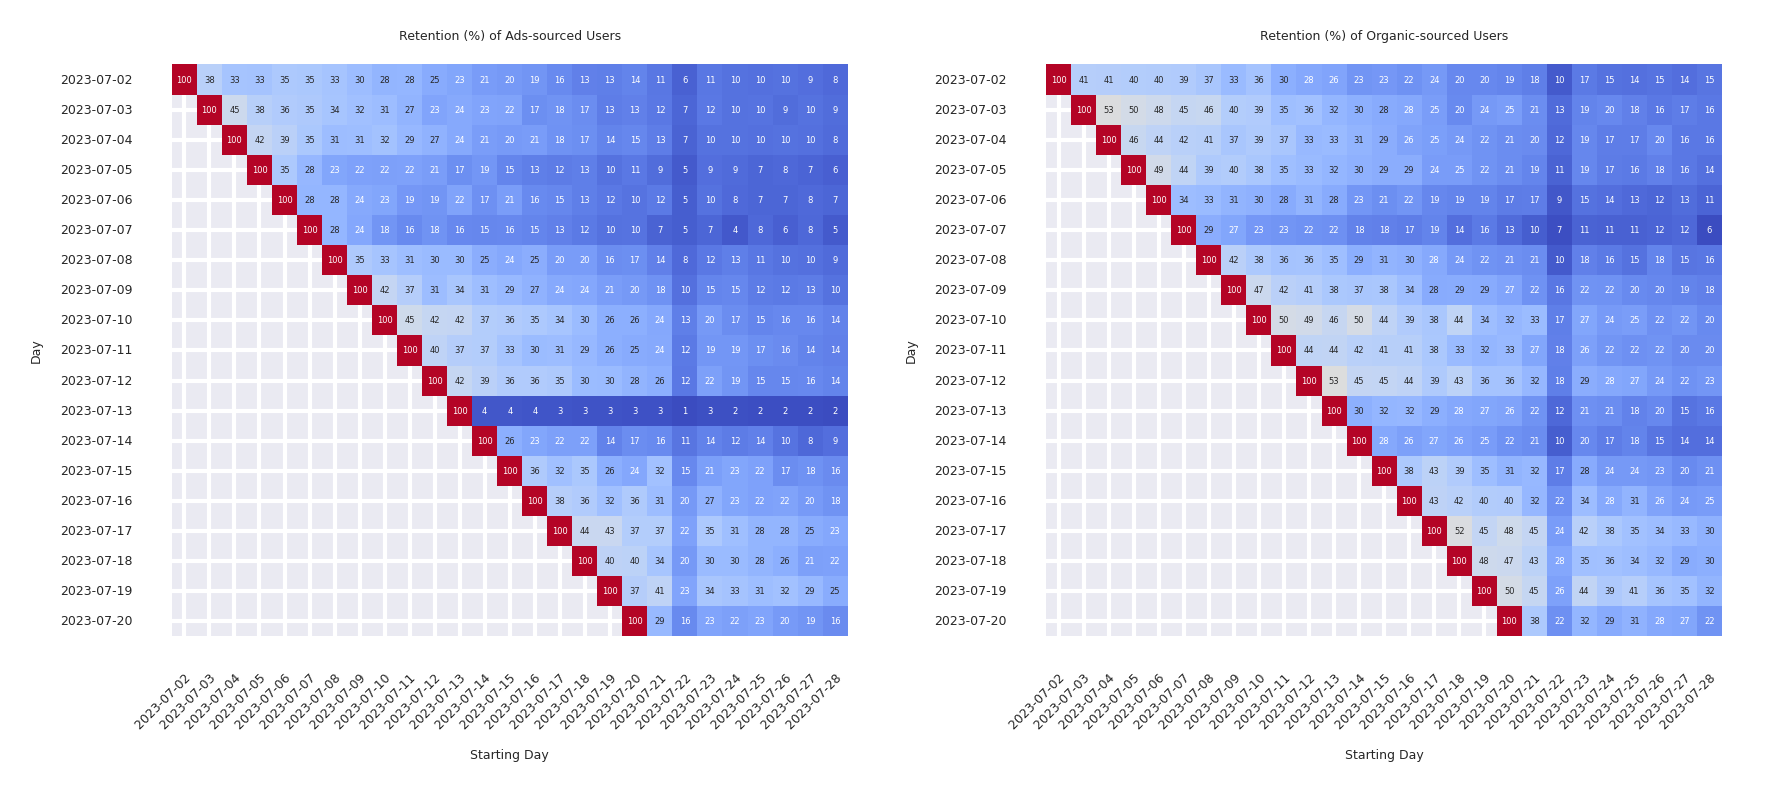

In [47]:
# now plot them without the values, back to back, with smaller size

fig, axs = plt.subplots(1, 2, figsize=(35 * SCALE, 15 * SCALE))

for ax, source, table in zip(axs, ['Ads', 'Organic'], [pivot_table_ads, pivot_table_organic]):
    
    # Plot the map
    heatmapper(
        table, 
       ax=ax, 
       title=f'Retention (%) of {source}-sourced Users', 
       xlabel='Starting Day',
       ylabel='Day',
       SCALE = SCALE
    )

plt.tight_layout(w_pad=2)


By eye, there is not much of a difference: ads-sourced users coming on 13 July are less retained than organic-sourced ones. Apart from that, it's hard to see.  
Let's plot the heatmap of the difference in the retention rate (%) between organic and ads-sourced users. 

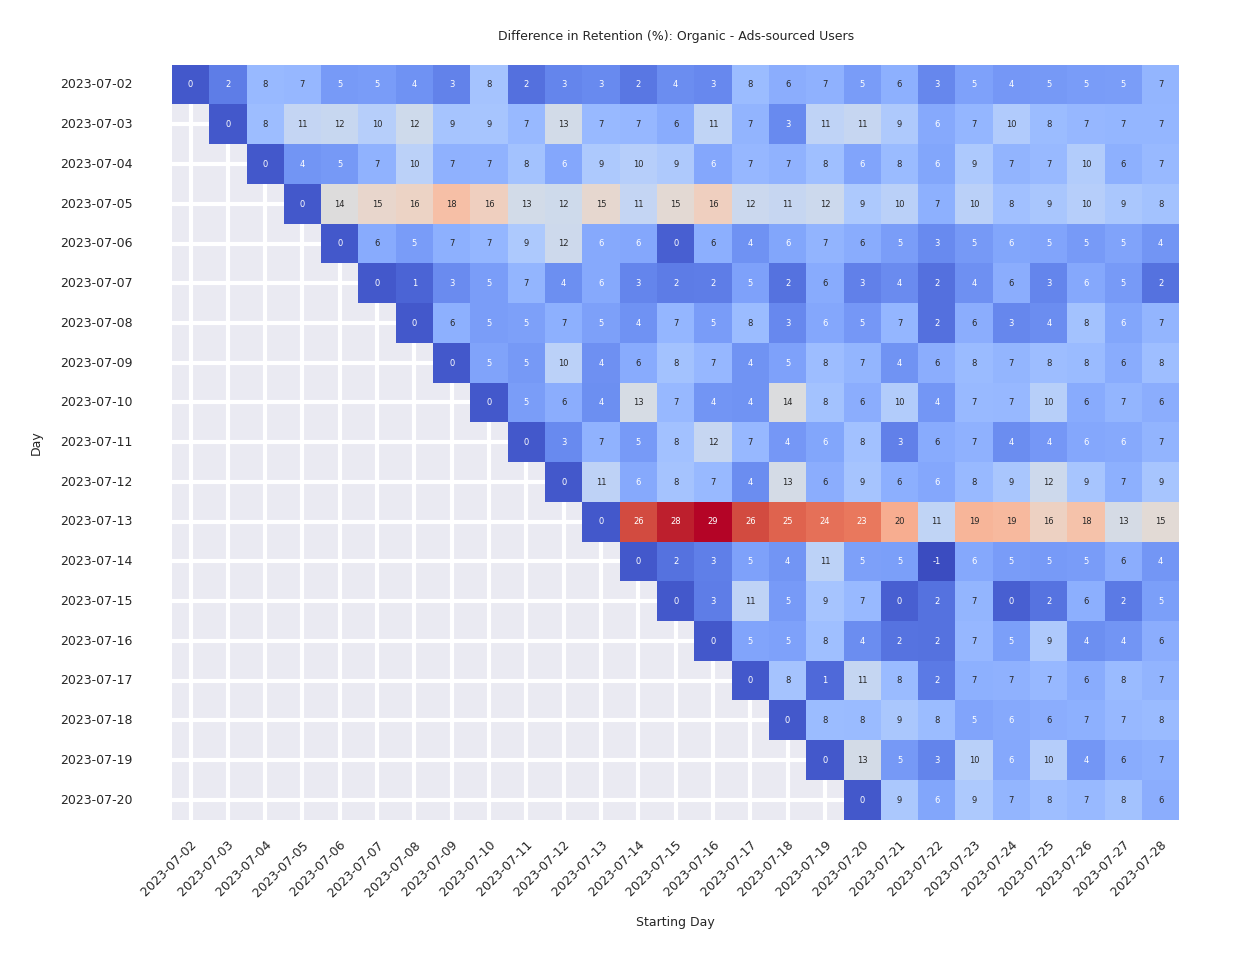

In [48]:
# now plot the heatmap of the difference of the RR between the two groups

# create a new columns with the difference
users_by_day_source['organic_subtracted_ads'] = users_by_day_source['retained_percentage_organic'].sub(users_by_day_source['retained_percentage_ads'])

# Create a pivot table to reshape the data
pivot_table_delta = users_by_day_source.pivot_table(index='start_day', columns='day', values='organic_subtracted_ads')

fig, ax = plt.subplots(figsize=(26 * SCALE, 20 * SCALE))

# Plot the map
heatmapper(
    pivot_table_delta, 
    ax=ax, 
    title='Difference in Retention (%): Organic - Ads-sourced Users', 
    xlabel='Starting Day',
    ylabel='Day',
    SCALE = SCALE
)


In general, retention is better in organic-sourced users (difference is always positive in this heatmap) - makes sense, as it is harder to keep a user via only ad campaign!  
There are 3 cohorts where the difference is the biggest:
1. 13 July - Big ad campaign was carried out.
2. 5 July - also campaign? Can be related to AB test carried out at the time?
3. 3 July - not that strong but different from other cohorts.

In the rest cohorts, the difference is not that strong.  
Let's take a "normal" week where the weekly averaged difference is close to the median value and compare RR between the groups.

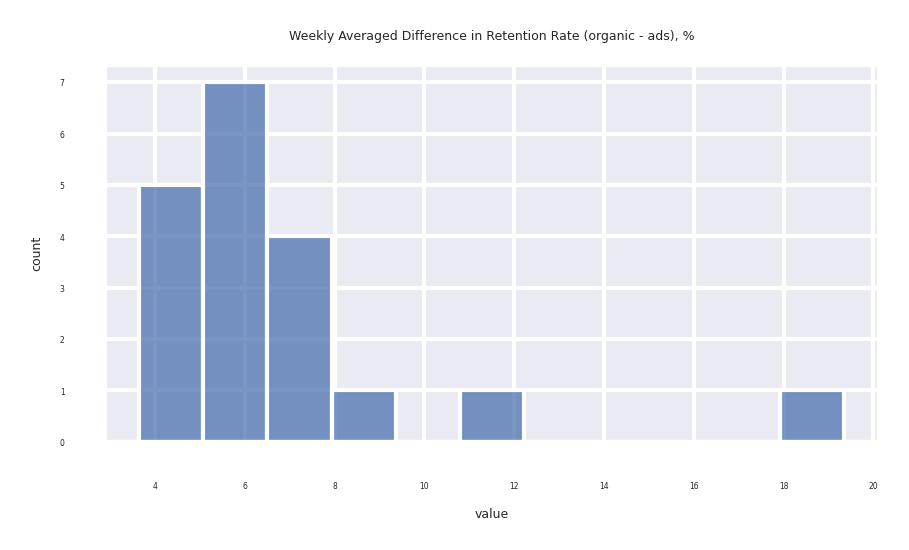

In [49]:
# look at how the weekly averaged difference of RR (%) is distributed
# across the weeks

fig, ax = plt.subplots(figsize=(20 * SCALE, 10 * SCALE))

sns.histplot(pivot_table_delta.mean(axis=1), ax=ax)
ax.set_title('Weekly Averaged Difference in Retention Rate (organic - ads), %', fontsize=18 * SCALE)
ax.set_xlabel('value', fontsize=18 * SCALE)
ax.set_ylabel('count', fontsize=18 * SCALE)

plt.show()


Let's take 6 July as a start date (its mean RR difference lies at the median of the RR% distribution) and compare 2-week retention rate for the groups.

In [50]:
# make a filter to take rows with users started on 6 July and their count on 6 and 20 July
condition = (users_by_day_source.start_day == '2023-07-06') & users_by_day_source.day.isin(['2023-07-06', '2023-07-20'])

# create a dataframe with the filter and calculate ratio of users at the end of 2-week period
# to the start of the period
users_after_2_weeks = users_by_day_source.loc[condition][['day', 'users_ads', 'users_organic']]
users_after_2_weeks = users_after_2_weeks.set_index(['day']).T
users_after_2_weeks.rename(columns={'2023-07-06': 'at_start_day', '2023-07-20': 'at_2_weeks'}, inplace=True)

users_after_2_weeks['as_percent_after_2_weeks'] = users_after_2_weeks.iloc[:, 1].div(users_after_2_weeks.iloc[:, 0]).mul(100)

users_after_2_weeks


day,at_start_day,at_2_weeks,as_percent_after_2_weeks
users_ads,374,39,10.427807
users_organic,583,97,16.638079


On an average day (e.g., not campaign/AB-test/bug-related day), there is about 6% difference in retention!  
Ads-sourced users seem to be less connected with the product, which again makes sense.  
Here, we could have used Chi-Square test and compare the retention rate on a statistical level.   
However, sample sizes are *too small* for any decent quality of the test - **we need roughly 800 users per group to have power at 95% and significance level at 5% to detect such changes (17 to 10% drop)**.

##### Summary:
The users coming via usual, organic way, are generally more attached to the product than those coming via ads. This is most obvious at 13 July, when ad-campaign was carried out and most ad-sourced users churned within days.  
However, if we want to detect a statistically significant result for an average week, we would need more users to compare.

---

#### Problem 2

Marketers launched a massive advertising campaign, which resulted in a significant influx of new users to the application, as seen from the spike in the active audience graph on **13 July**.  
However, we have doubts about the quality of the traffic. Let's investigate what happens to the ad-acquired users in the future and how often they continue using the application.

To do:
1. Look at the delta heatmap for RR between two sources - slice it for clarity so it starts week before the campaign (6 July).
2. Compare RR for Ads-sourced users - starting on the campgain day and those who came week before (control day) - any difference?
3. Compare unique views per user, likes per user, CTR - daily metrics for the campgain-sourced users and the control.

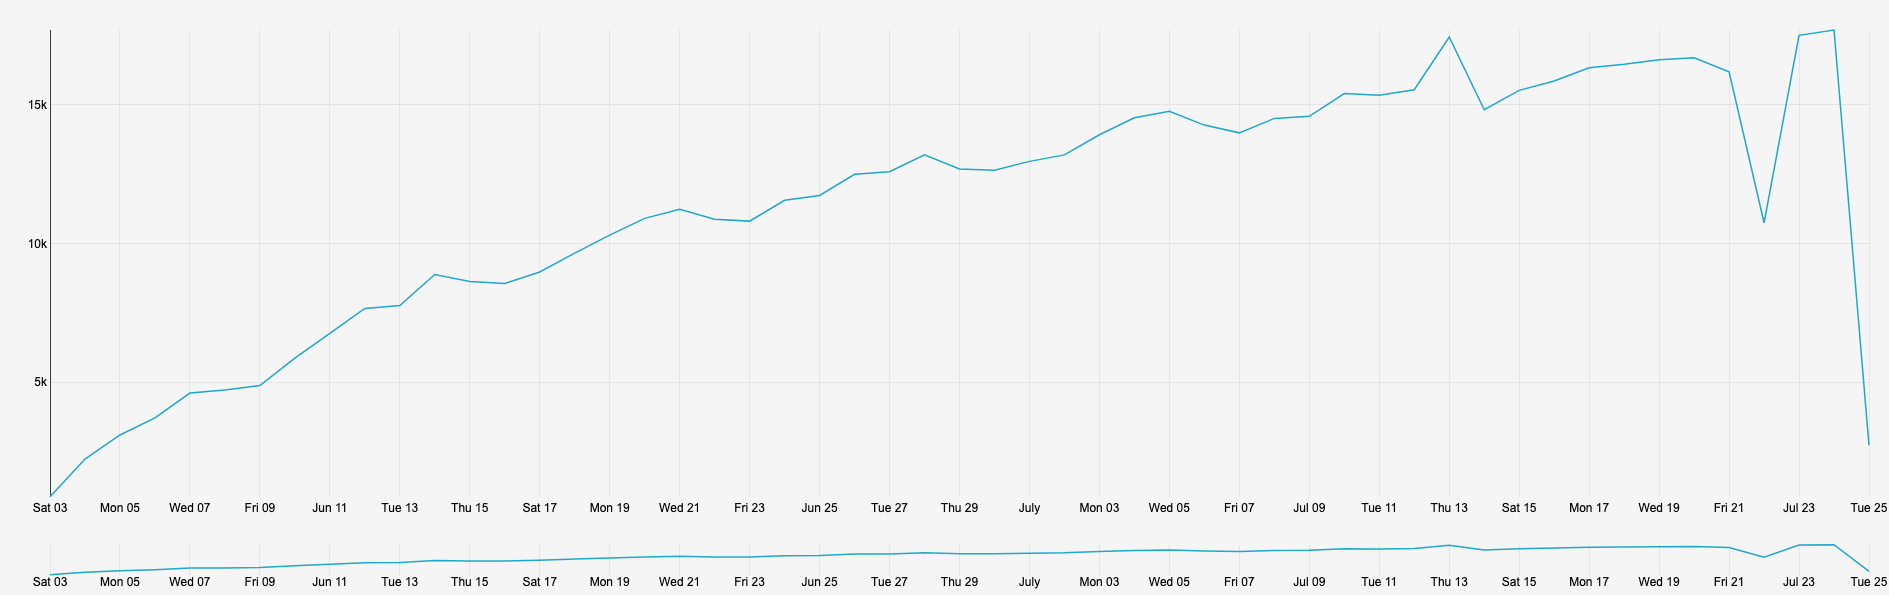

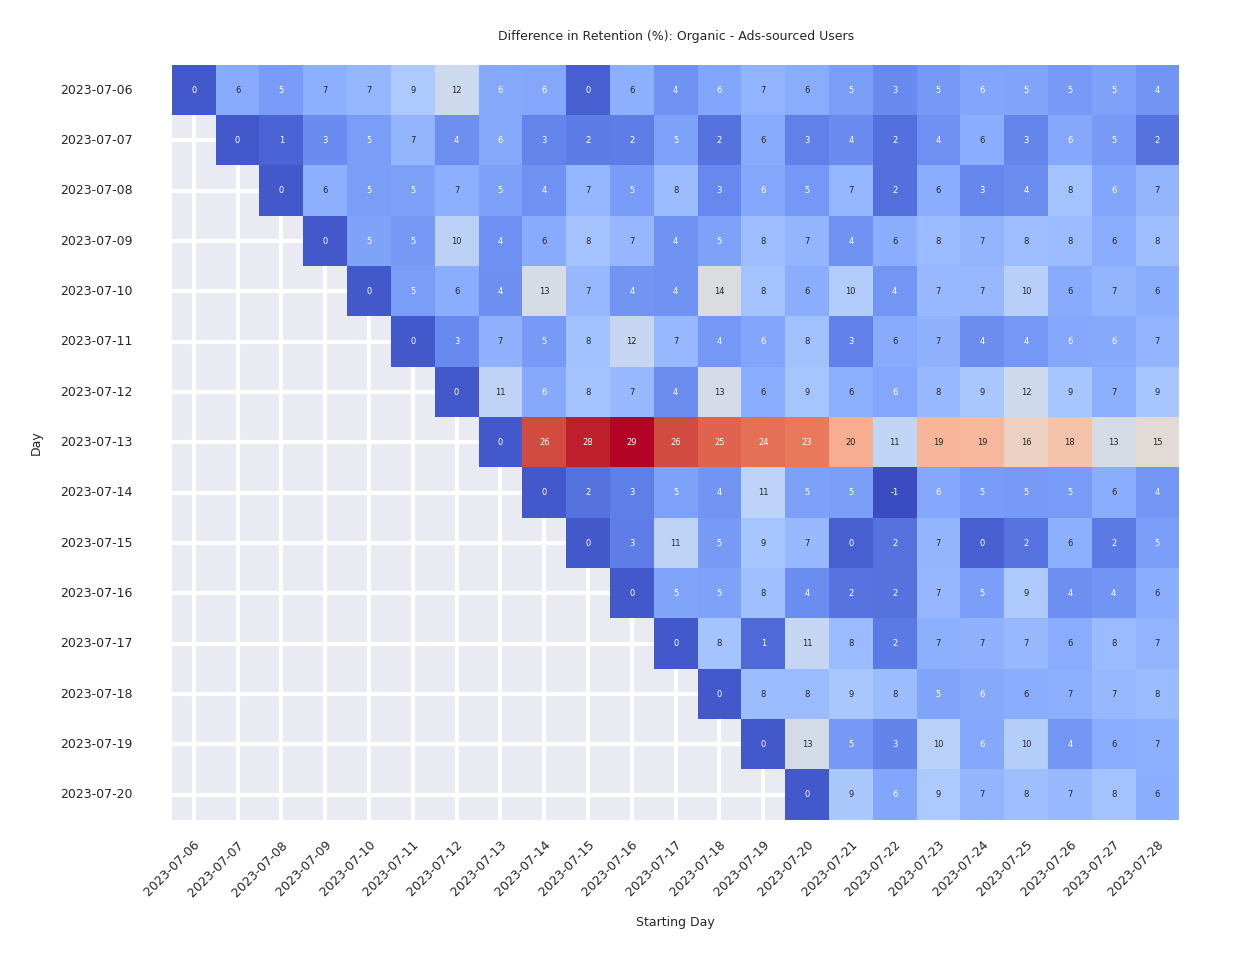

In [51]:
# 1. Create a pivot table (RR % difference) to reshape the data
# with starting days >= 1 week before the campaign

pivot_table_delta = users_by_day_source.loc[(users_by_day_source.start_day >= '2023-07-06')].pivot_table(index='start_day', columns='day', values='organic_subtracted_ads')

fig, ax = plt.subplots(figsize=(26 * SCALE, 20 * SCALE))

# Plot the map
heatmapper(
    pivot_table_delta, 
    ax=ax, 
    title='Difference in Retention (%): Organic - Ads-sourced Users', 
    xlabel='Starting Day',
    ylabel='Day',
    SCALE = SCALE
)


In [52]:
# 2. Now look at the 1-week RR for ads-sourced users
# and compare those who came 13/7/23 (campaign) and 6/7/23 (control)

# convert dates from strings to datetime objects
users_by_day_source = users_by_day_source.astype(
    {'start_day': 'datetime64[ns]', 'day': 'datetime64[ns]'}
)

# Define the dates to filter
start_days = pd.to_datetime(['2023-07-06', '2023-07-13'])

# make a filter to select rows with 1 week offset with the start date
condition = (users_by_day_source['start_day'].isin(start_days)) & (users_by_day_source['day'] - users_by_day_source['start_day'] == pd.Timedelta(days=7))

# apply the filter
compare_rr_campaign = users_by_day_source.loc[condition, 
               ['day', 'start_day', 'users_ads', 'users_ads_start', 'retained_percentage_ads']].set_index('start_day')

compare_rr_campaign


,day,users_ads,users_ads_start,retained_percentage_ads
start_day,,,,
2023-07-06,2023-07-13,84,374.0,22.459893
2023-07-13,2023-07-20,75,2592.0,2.893519


Based on the Sample Size calculator (22.5% baseline, 20% MDE, 95% power, 5% significance level),  we need approx 130 users per variation - OK for us (https://www.evanmiller.org/ab-testing/sample-size.html).  
Let's do Chi-Square test.

In [53]:
# create a column with churned users: users at the start - users left after 1 week
compare_rr_campaign['churned'] = compare_rr_campaign['users_ads_start'].sub(compare_rr_campaign['users_ads'])

# rename and transform our df to make it suitable for the analysis
array_for_test = compare_rr_campaign.rename(columns={'users_ads': 'retained'})[['retained', 'churned']].T

# Perform the chi-square test for retention rates
chi2, p, dof, expected = chi2_contingency(array_for_test)

# Create a DataFrame to store the chi-square test results
results_df = pd.DataFrame({
    'Chi-Square Statistic': [chi2],
    'P-value': [p],
    'Degrees of Freedom': [dof]
})

# Add the expected frequencies to the results DataFrame
for i, row_label in enumerate(array_for_test.index):
    for j, col_label in enumerate(array_for_test.columns):
        results_df.at[row_label, col_label] = expected[i][j]

results_df

,Chi-Square Statistic,P-value,Degrees of Freedom,2023-07-06 00:00:00,2023-07-13 00:00:00
0,242.795801,9.662966e-55,1.0,NaN,NaN
retained,NaN,NaN,NaN,20.049225,138.950775
churned,NaN,NaN,NaN,353.950775,2453.049225


P-value is below our significance level and we have to decline the H0 - **difference in RR between campaign-sourced and non-campaign-sourced is significant**.  
What about other metrics of these two groups? Look at unique views per user, likes per user, CTR.  
For this, we need a table: userid, start_day, day, users, likes, unique_views, ctr.

In [54]:
#3.  Get a table with daily metrics aggregated by day
# for users who started on 13 July (target) and 6 July (control)
# within 7 days from their start
query = '''
WITH retained_users AS (

SELECT *
   FROM
     (SELECT user_id,
             min(toDate(time)) AS start_day
      FROM {db}.feed_actions
      GROUP BY user_id) t1
   JOIN
     (SELECT user_id,
     countIf(user_id, action = 'like') AS likes,
     uniq(post_id) AS unique_views,
     countIf(user_id, action = 'view') AS views,
        toDate(time) AS day
      FROM {db}.feed_actions
      WHERE source = 'ads'
      GROUP BY user_id, day) t2 USING user_id
   WHERE start_day >= today() - 30 AND start_day != today() AND day != today()
   
),

retained_users_by_date_source AS (

SELECT start_day,
       day,
     COUNT(user_id) AS users_ads,
     SUM(likes) AS likes,
     SUM(unique_views) AS unique_views,
     SUM(views) AS views
     
FROM retained_users
WHERE start_day IN ('2023-07-06'::DATE, '2023-07-13'::DATE) AND (day - start_day <= 7)
GROUP BY start_day,
         day
)

SELECT toString(start_day) start_day,
toString(day) day,
users_ads,
MAX(users_ads) OVER (PARTITION BY start_day) AS users_ads_start,
likes,
likes::FLOAT / users_ads AS likes_per_user,
unique_views::FLOAT / users_ads AS views_per_user,
unique_views,
views,
likes::FLOAT / views AS CTR
FROM retained_users_by_date_source

'''

# import a table to a dataframe
user_amount_with_metrics = ph.read_clickhouse(
    query, 
    connection=CONNECTION
).astype(
    dtype={'users_ads_start': 'float'}
) 


In [55]:
user_amount_with_metrics.info()
user_amount_with_metrics.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   start_day        16 non-null     object 
 1   day              16 non-null     object 
 2   users_ads        16 non-null     uint64 
 3   users_ads_start  16 non-null     float64
 4   likes            16 non-null     uint64 
 5   likes_per_user   16 non-null     float64
 6   views_per_user   16 non-null     float64
 7   unique_views     16 non-null     uint64 
 8   views            16 non-null     uint64 
 9   CTR              16 non-null     float64
dtypes: float64(4), object(2), uint64(4)
memory usage: 1.4+ KB


,start_day,day,users_ads,users_ads_start,likes,likes_per_user,views_per_user,unique_views,views,CTR
0,2023-07-06,2023-07-12,70,374.0,462,6.600000,25.342857,1774,2162,0.213691
1,2023-07-06,2023-07-13,84,374.0,622,7.404762,29.202381,2453,2856,0.217787
2,2023-07-06,2023-07-09,91,374.0,544,5.978022,27.285714,2483,2899,0.187651
3,2023-07-06,2023-07-08,106,374.0,809,7.632075,31.839623,3375,4166,0.194191
4,2023-07-06,2023-07-07,105,374.0,774,7.371429,29.619048,3110,3711,0.208569


In [56]:
# Create a function that plots a lineplot on a given grid
def lineplotter(
    data: pd.DataFrame,
    x: str,
    y: str,
    ax: axes._axes.Axes,
    hue: str = None,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None,
    SCALE: int = 1 / 6,
    ) -> None:
    """
    Plots a lineplot for the given dataframe (table) on the given axis (ax)
    """
    fontsize = 30
    labelsize = 25
    
    # Check the label values and infer those not set from the table:
    if not ylabel:
        ylabel = y
    if not xlabel:
        xlabel = x
    if not title:
        title = f"{ylabel} vs {xlabel}"
        
    # Plot the heatmap of the retention of ad-sourced users
    sns.lineplot(
        data=user_amount_with_metrics,
        x=x, 
        y=y, 
        hue=hue,
        marker='o', 
        ax=ax,
        markersize=12 * SCALE, 
        linewidth=4 * SCALE
    )
    
    ax.set_title(title, fontsize=fontsize * SCALE)
    ax.set_xlabel(xlabel, fontsize=fontsize * SCALE)
    ax.set_ylabel(ylabel, fontsize=fontsize * SCALE)
    
    ax.tick_params(axis='x', rotation=45, labelsize=labelsize * SCALE)
    ax.tick_params(axis='y', rotation=0, labelsize=labelsize * SCALE)
    
    ax.legend(fontsize=labelsize * SCALE)

In [57]:
# make a better-looking "group" column
user_amount_with_metrics['group'] = user_amount_with_metrics['start_day'].apply(lambda x: 'non-campaign control' if x == '2023-07-06' else 'campaign-sourced')

# Convert 'start_day' and 'day' columns to datetime type
user_amount_with_metrics['start_day'] = pd.to_datetime(user_amount_with_metrics['start_day'])
user_amount_with_metrics['day'] = pd.to_datetime(user_amount_with_metrics['day'])

# set days to the same range by substracting the dates
user_amount_with_metrics['day_normalized'] = user_amount_with_metrics['day'].sub(user_amount_with_metrics['start_day'])

# Convert 'start_day' column back to string
user_amount_with_metrics = user_amount_with_metrics.astype(
    dtype={'start_day': 'object'}
) 

In [58]:
user_amount_with_metrics.head()

,start_day,day,users_ads,users_ads_start,likes,likes_per_user,views_per_user,unique_views,views,CTR,group,day_normalized
0,2023-07-06 00:00:00,2023-07-12,70,374.0,462,6.600000,25.342857,1774,2162,0.213691,non-campaign control,6 days
1,2023-07-06 00:00:00,2023-07-13,84,374.0,622,7.404762,29.202381,2453,2856,0.217787,non-campaign control,7 days
2,2023-07-06 00:00:00,2023-07-09,91,374.0,544,5.978022,27.285714,2483,2899,0.187651,non-campaign control,3 days
3,2023-07-06 00:00:00,2023-07-08,106,374.0,809,7.632075,31.839623,3375,4166,0.194191,non-campaign control,2 days
4,2023-07-06 00:00:00,2023-07-07,105,374.0,774,7.371429,29.619048,3110,3711,0.208569,non-campaign control,1 days


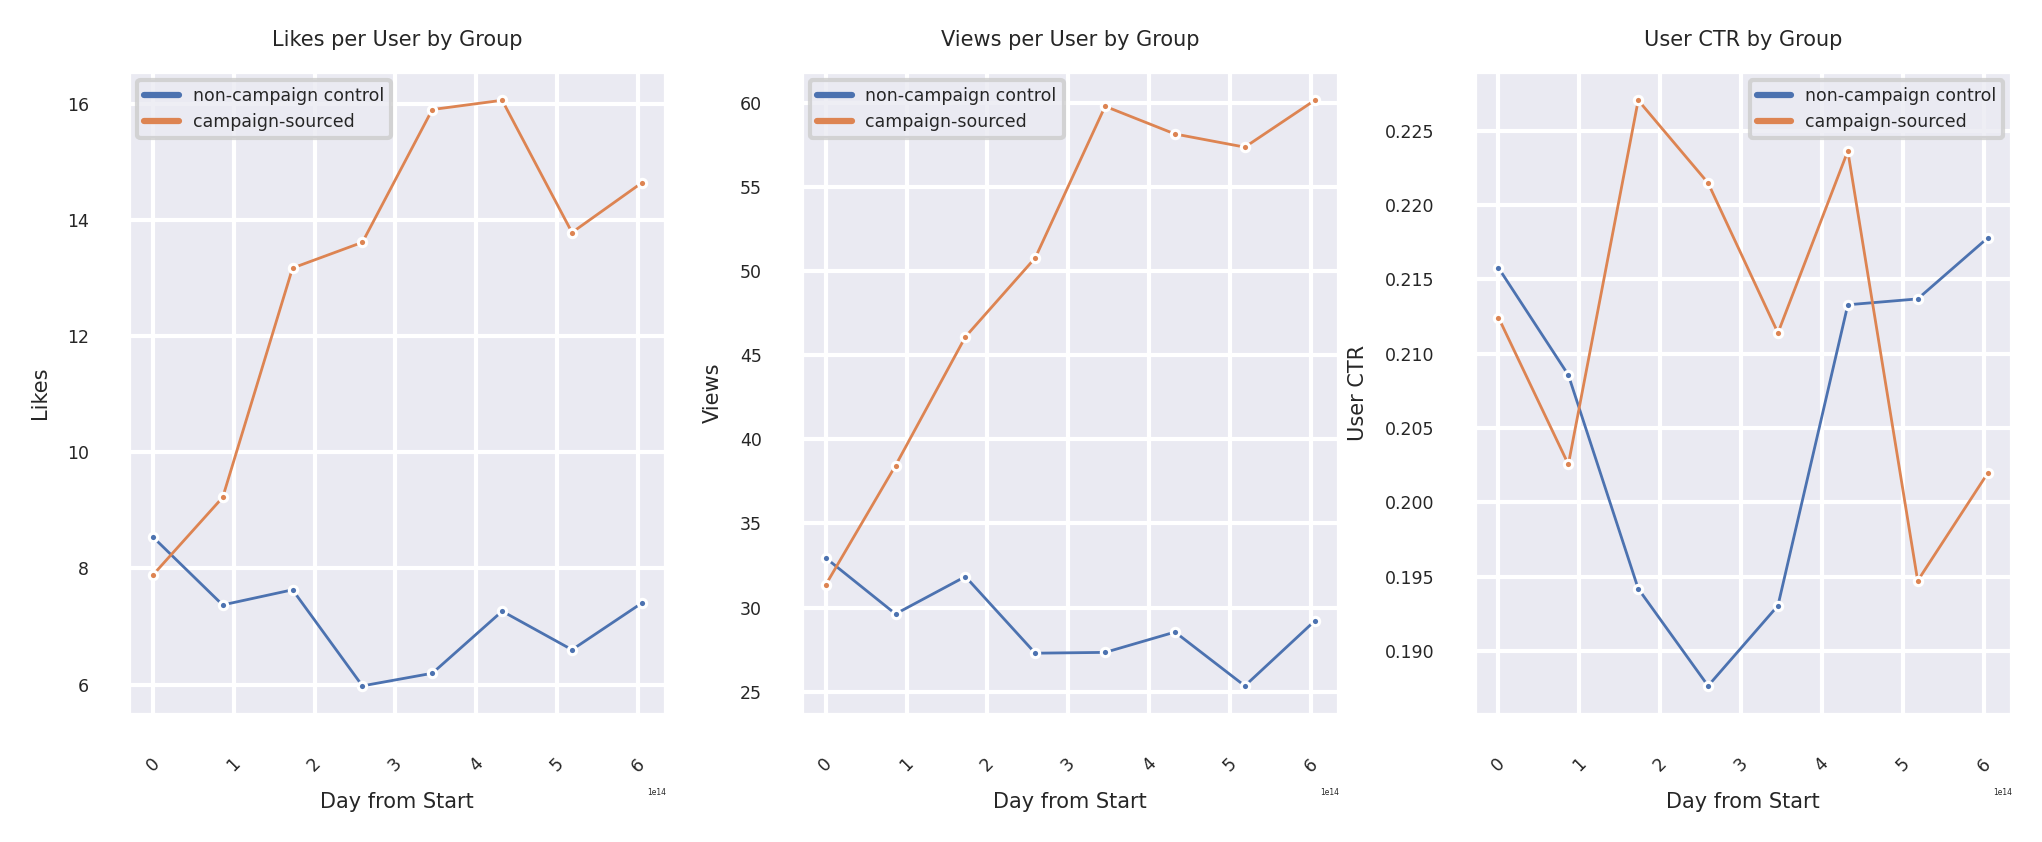

In [59]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(40 * SCALE, 16 * SCALE))

# Plot "likes_per_user" over "day" for two groups based on "group"
lineplotter(
    data=user_amount_with_metrics,
    x='day_normalized', 
    y='likes_per_user', 
    hue='group',
    ax=axs[0],
    title='Likes per User by Group',
    xlabel='Day from Start',
    ylabel='Likes'
)

# Plot "views_per_user" over "day" for two groups based on "group"
lineplotter(
    data=user_amount_with_metrics,
    x='day_normalized', 
    y='views_per_user', 
    hue='group',
    ax=axs[1],
    title='Views per User by Group',
    xlabel='Day from Start',
    ylabel='Views'
)

# Plot "CTR" over "day" for two groups based on "group"
lineplotter(
    data=user_amount_with_metrics,
    x='day_normalized', 
    y='CTR', 
    hue='group',
    ax=axs[2],
    title='User CTR by Group',
    xlabel='Day from Start',
    ylabel='User CTR'
)

plt.tight_layout()


##### Summary:

Campgain-sourced users have lower 1-week retention rate than a control ads-sourced group who joined 1 week before.  
The Campgain-sourced group, however, shows higher rates of likes and views per user despite lower retention. Their CTR tended to be higher in the first few days and then left below control CTR.  
In short, it may be useful to put efforts into the keeping these Campgain-sourced users - they tend to have higher metrics.

---

#### Problem 3

We are observing a sudden drop in the active users on 22 July! We need to understand which users were unable to access the application and what factors might be common among them.  

To do:  
As we can see from DAU plot, amount of users was restored on 23 July. It can be that the users absent on 22 July are present after the drop on 23 July.  
So, we can compare users that were present after the drop, but not on the drop day, with users present on drop day.  
Compare the groups by: 
  - OS type, 
  - gender, 
  - their source, 
  - age group, 
  - country, 
  - city

In [60]:
# get the data for active users on 22 July (drop) and 23 July (after the drop)
query = '''
-- users present after and NOT on drop date
WITH lost_on_drop AS (

SELECT DISTINCT user_id FROM {db}.feed_actions WHERE toDate(time) = '2023-07-23'::DATE
EXCEPT
SELECT DISTINCT user_id FROM {db}.feed_actions WHERE toDate(time) = '2023-07-22'::DATE
),

-- users present on drop date
stayed_on_drop AS (

SELECT DISTINCT user_id FROM {db}.feed_actions WHERE toDate(time) = '2023-07-22'::DATE
),

-- users classified by drop presence with their data, start date, and likes/views by day
users_classified_with_start_date AS (

SELECT *
   FROM
     (SELECT user_id,
             min(toDate(time)) AS start_day, 
             gender, 
             os, 
             country, 
             city,
             source,
             multiIf(age <= 16, '0-15', age > 16 and age <= 30, '16-30', age > 30 and age <= 55, '30-55', '55+') AS age_group
      FROM {db}.feed_actions
      GROUP BY user_id,
      gender, 
             os, 
             country,
             city,
             age_group,
             source
             ) t1
   JOIN
     (SELECT user_id,
     countIf(user_id, action = 'like') AS likes,
     countIf(user_id, action = 'view') AS views,
     toDate(time) AS day
      FROM {db}.feed_actions
      WHERE (toDate(time) = '2023-07-23'::DATE AND user_id IN (SELECT * FROM lost_on_drop))
      OR (toDate(time) = '2023-07-22'::DATE AND user_id IN (SELECT * FROM stayed_on_drop))
      GROUP BY user_id, day) t2 USING user_id
)

SELECT user_id,
if(day='2023-07-23'::DATE, 'control', 'on_drop') AS group,
likes,
views,
toString(start_day) AS start_day,
gender, 
os, 
country, 
city,
age_group,
source
FROM users_classified_with_start_date 
WHERE toString(day) != start_day 
'''

# import a table to a dataframe
users_by_drop = ph.read_clickhouse(
    query, 
    connection=CONNECTION
) 


In [61]:
users_by_drop.info()
users_by_drop.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21225 entries, 0 to 21224
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    21225 non-null  uint32
 1   group      21225 non-null  object
 2   likes      21225 non-null  uint64
 3   views      21225 non-null  uint64
 4   start_day  21225 non-null  object
 5   gender     21225 non-null  int8  
 6   os         21225 non-null  object
 7   country    21225 non-null  object
 8   city       21225 non-null  object
 9   age_group  21225 non-null  object
 10  source     21225 non-null  object
dtypes: int8(1), object(7), uint32(1), uint64(2)
memory usage: 1.6+ MB


,user_id,group,likes,views,start_day,gender,os,country,city,age_group,source
0,37739,on_drop,16,95,2023-07-11,1,Android,Russia,Zhukovskiy,30-55,ads
1,129683,control,7,54,2023-06-26,1,iOS,Russia,Moscow,0-15,organic
2,106827,on_drop,3,21,2023-06-04,0,Android,Russia,Novokuznetsk,30-55,ads
3,7707,control,20,111,2023-06-14,1,Android,Russia,Orël,0-15,ads
4,130976,on_drop,10,38,2023-06-27,1,iOS,Russia,Tula,30-55,organic
5,120024,control,11,59,2023-06-17,0,iOS,Russia,Nizhniy Tagil,30-55,organic
6,49729,control,13,53,2023-07-16,1,Android,Russia,Moscow,30-55,ads
7,135426,control,5,37,2023-07-01,1,iOS,Russia,Moscow,16-30,organic
8,144114,on_drop,6,19,2023-07-13,0,Android,Russia,Novosibirsk,30-55,organic
9,150999,control,6,21,2023-07-19,0,Android,Russia,Yarag-Kazmalyar,16-30,organic


In [62]:
# create a function that would build bar plots and shorten these tediously long lines!
def barplotter(
    data, 
    title,
    xlabel, 
    ylabel, 
    ax, 
    stacked=False,
    SCALE=1 / 6
):
    """
    Build a bar plot using the provided data, title, xlabel, ylabel, and ax instance.

    Parameters:
        data (pd.Series): The data to plot (Pandas Series).
        title (str): The title of the plot.
        xlabel (str): The label for the X-axis.
        ylabel (str): The label for the Y-axis.
        ax (matplotlib.axes._subplots.AxesSubplot): The AxesSubplot instance to plot on.
        stacked (bool, optional): Whether to stack the bars (default is False).
        SCALE (float, optional): Scale factor for adjusting font size (default is 1/6).

    Returns:
        None
    """

    fontsize = 25 * SCALE
    
    if stacked:
        data = data.unstack()

    # Plot the data as a bar plot on the given ax
    data.plot(kind="bar", ax=ax, stacked=stacked, rot=0)

    # Set the title, xlabel, and ylabel
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)

    # Set the tick labels font size for both X and Y axes
    ax.tick_params(axis='both', which='major', labelsize=20 * SCALE)

    # Rotate xtick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Increase the font size of the legend
    ax.legend(fontsize=20 * SCALE)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


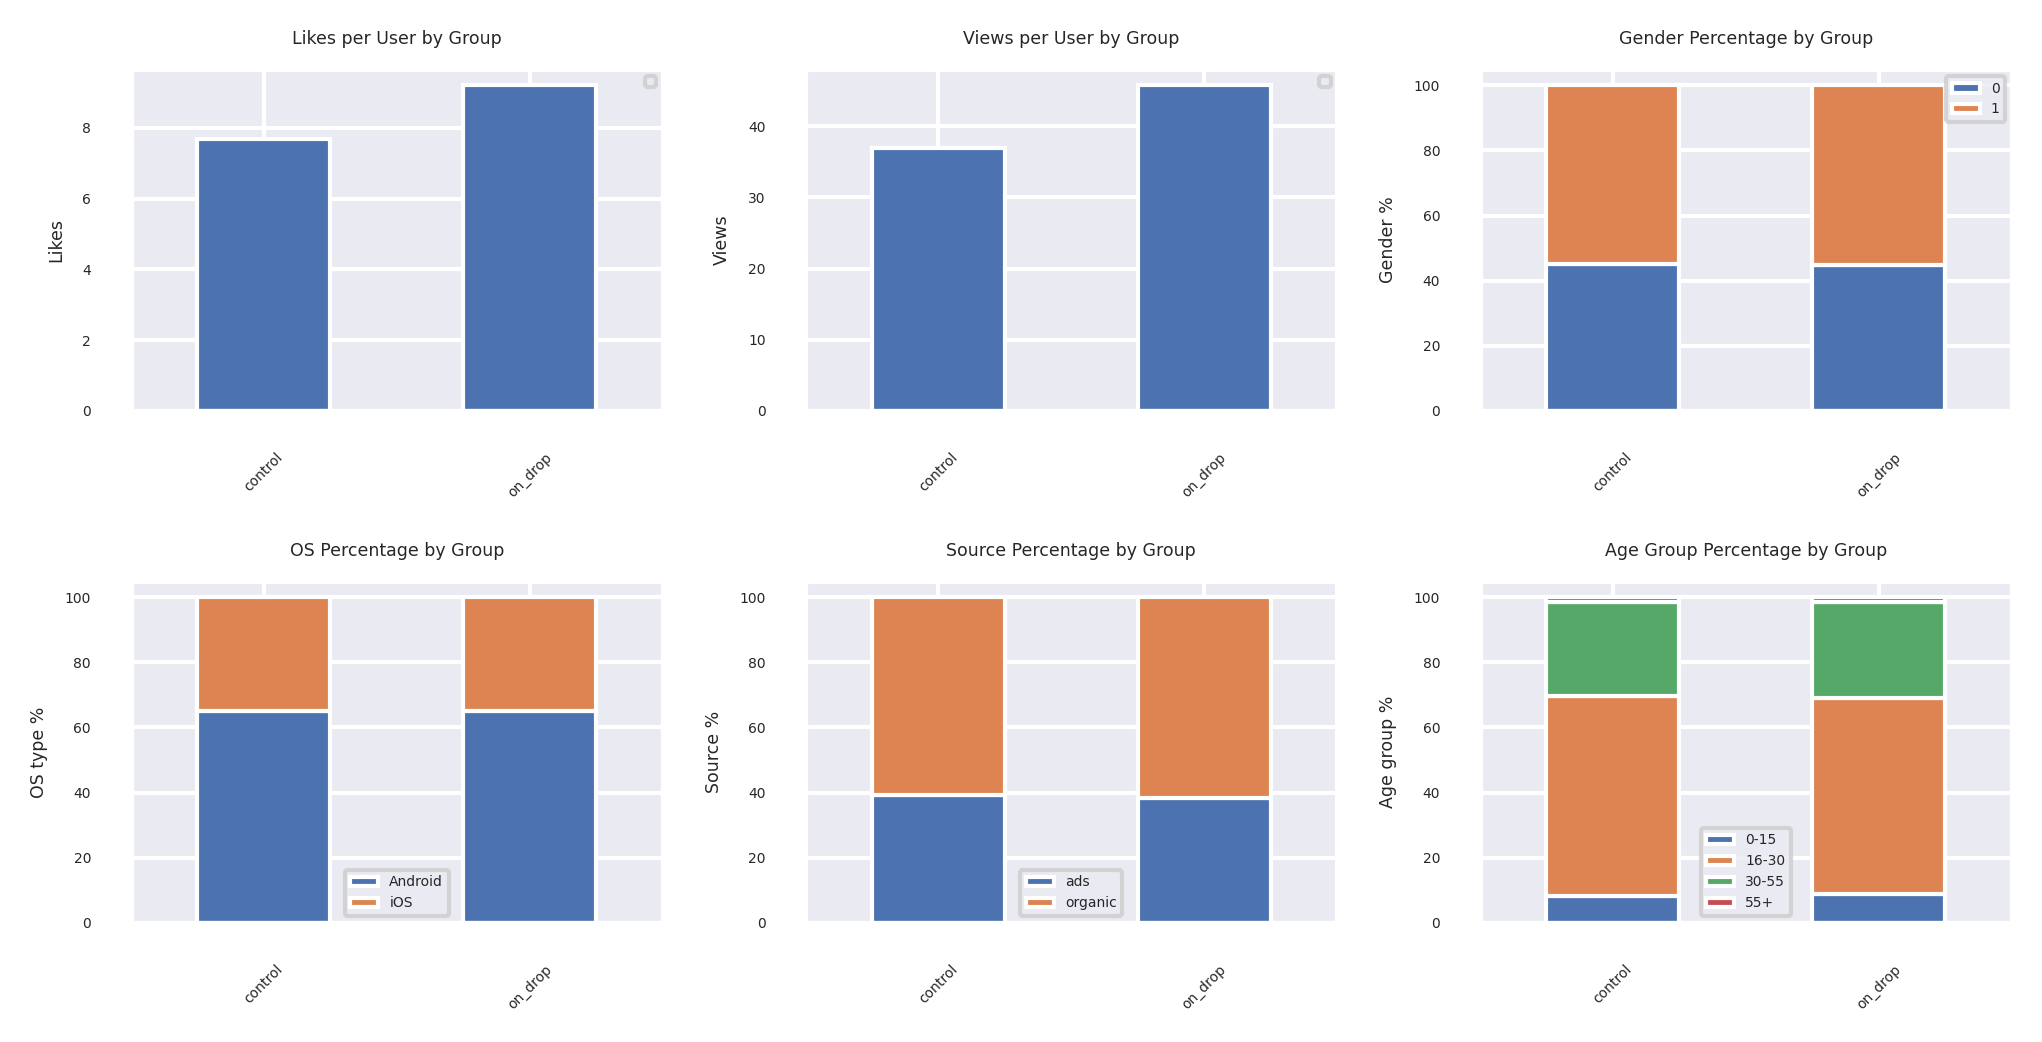

In [63]:
# Let's look at various metrics in between the two groups: on drop (target) and after the drop (control)
# Create a figure and subplot layout
fig, axs = plt.subplots(2, 3, figsize=(40 * SCALE, 20 * SCALE))

# Plot 1 - Likes per User by Group
# group by group type, calculate the sum of likes within the group, and divide by number of users within the group
likes_per_user = users_by_drop.groupby("group")["likes"].sum() / users_by_drop.groupby("group")["user_id"].count()
barplotter(likes_per_user, "Likes per User by Group", "", "Likes", axs[0, 0], stacked=False, SCALE=SCALE)

# Plot 2 - Views per User by Group
views_per_user = users_by_drop.groupby("group")["views"].sum() / users_by_drop.groupby("group")["user_id"].count()
barplotter(views_per_user, "Views per User by Group", "", "Views", axs[0, 1], stacked=False, SCALE=SCALE)

# Plot 3 - Percentage of 0 and 1 in Gender by Group
gender_percentage = users_by_drop.groupby(["group", "gender"])["user_id"].count() / users_by_drop.groupby("group")["user_id"].count() * 100
# gender_percentage.unstack().plot(kind="bar", stacked=True, ax=axs[0, 2], rot=0)
barplotter(gender_percentage, "Gender Percentage by Group", "", "Gender %", axs[0, 2], stacked=True, SCALE=SCALE)
axs[0, 2].legend(fontsize=20 * SCALE)

# Plot 4 - Percentage of Android and iOS in OS by Group
os_percentage = users_by_drop.groupby(["group", "os"])["user_id"].count() / users_by_drop.groupby("group")["user_id"].count() * 100
# os_percentage.unstack().plot(kind="bar", stacked=True, ax=axs[1, 0], rot=0)
barplotter(os_percentage, "OS Percentage by Group", "", "OS type %", axs[1, 0], stacked=True, SCALE=SCALE)

# Plot 5 - Percentage of ads and organic in Source by Group
source_percentage = users_by_drop.groupby(["group", "source"])["user_id"].count() / users_by_drop.groupby("group")["user_id"].count() * 100
# source_percentage.unstack().plot(kind="bar", stacked=True, ax=axs[1, 1], rot=0)
barplotter(source_percentage, "Source Percentage by Group", "", "Source %", axs[1, 1], stacked=True, SCALE=SCALE)

# Plot 6 - Percentage of Each Age Group by Group
age_group_percentage = users_by_drop.groupby(["group", "age_group"])["user_id"].count() / users_by_drop.groupby("group")["user_id"].count() * 100
# age_group_percentage.unstack().plot(kind="bar", stacked=True, ax=axs[1, 2], rot=0)
barplotter(age_group_percentage, "Age Group Percentage by Group", "", "Age group %", axs[1, 2], stacked=True, SCALE=SCALE)

# Adjust layout and show the plots
plt.tight_layout(w_pad=5, h_pad=5)

# Show the plot
plt.show()


The two groups, users who likely were absent of the drop day and users that were present that day, do not seem to differ much by OS type (excludes OS-related bugs), source (end of free subscriptions?) and age (age-related holidays?).  
Let's have a look at more metrics: starting day, country, city of the user.

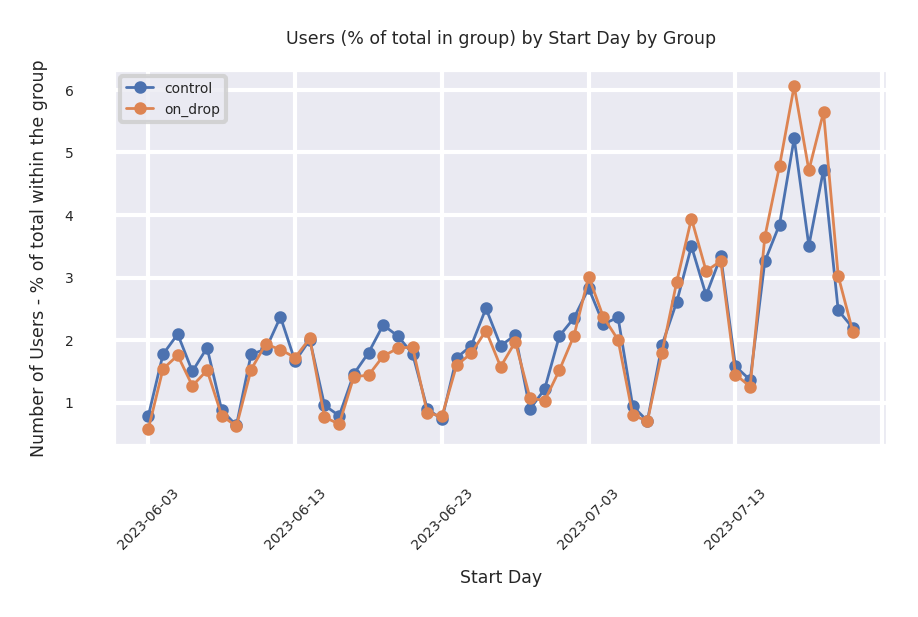

In [64]:
# Compare starting day pattterns for the groups
# Create a figure and axis, set font size
fig, ax = plt.subplots(figsize=(20 * SCALE, 10 * SCALE))

fontsize = 25
labelsize = 20

# aggregate by group and starting day, count the users, 
# find the total amount of users per group 
# and normalize counts on every day by it
normalizer = users_by_drop.groupby(["group", "start_day"])["user_id"].count().unstack().T.sum()
new = users_by_drop.groupby(["group", "start_day"])["user_id"].count().unstack().T * 100 / normalizer
new.plot(ax=ax, marker='o', linestyle='-', markersize=12 * SCALE, linewidth=4 * SCALE)

# Set plot properties
plt.title("Users (% of total in group) by Start Day by Group", fontsize=fontsize * SCALE)
plt.xlabel("Start Day", fontsize=fontsize * SCALE)
plt.ylabel("Number of Users - % of total within the group", fontsize=fontsize * SCALE)

ax.tick_params(axis='x', rotation=45, labelsize=labelsize * SCALE)
ax.tick_params(axis='y', rotation=0, labelsize=labelsize * SCALE)
ax.legend(fontsize=labelsize * SCALE)

plt.show()

No difference. Last steps - see the composition by countries/cities - any difference between the groups?

In [65]:
# this time, similarly aggregate by the group and the country
# and see contribution of every country for each group
number_by_group_country = users_by_drop.groupby(["group", "country"])["user_id"].count().unstack().T.sort_values(by="control", ascending=False)
total_in_group = users_by_drop.groupby("group")["user_id"].count()

number_by_group_country = number_by_group_country.div(total_in_group).mul(100)
number_by_group_country['delta'] = number_by_group_country.on_drop.sub(number_by_group_country.control)

number_by_group_country.sort_values(by='delta')

group,control,on_drop,delta
country,,,
Belarus,2.209677,1.892351,-0.317326
Azerbaijan,1.080645,0.917847,-0.162798
Kazakhstan,2.000000,1.858357,-0.141643
Russia,87.387097,87.252125,-0.134972
Finland,1.153226,1.087819,-0.065407
Latvia,0.112903,0.056657,-0.056246
Turkey,0.967742,0.917847,-0.049895
Estonia,0.072581,0.067989,-0.004592
Cyprus,0.072581,0.113314,0.040734


On a drop day, we had less users from certain countries - the drop is not uniform. Could be that there was region-specific issues with the access to the feed.  
Finally, let's look at the cities and their contribution. Is there any non-uniformity in drop there?

In [66]:
number_by_group_city_right = users_by_drop.groupby(["group", "city"])["user_id"].count().unstack().T.sort_values(by="control", ascending=False)
total_in_group = users_by_drop.groupby("group")["user_id"].count()

number_by_group_city_normalized = (number_by_group_city_right * 100 / total_in_group).dropna()
number_by_group_city_normalized['delta_relative'] = number_by_group_city_normalized.on_drop.sub(number_by_group_city_normalized.control)

condition = np.abs(number_by_group_city_normalized.delta_relative) > 0.1

number_by_group_city_normalized = number_by_group_city_normalized.loc[condition]
name_dict = {name: name + '_relative' for name in number_by_group_city_right.columns}
number_by_group_city_normalized.rename(columns=name_dict, inplace=True)
number_by_group_city_normalized

number_by_group_city = number_by_group_city_normalized.join(number_by_group_city_right, how='left', on='city')

number_by_group_city['delta'] = number_by_group_city.on_drop.sub(number_by_group_city.control)
number_by_group_city.sort_values(by='delta', inplace=True)


In [67]:
number_by_group_city

group,control_relative,on_drop_relative,delta_relative,control,on_drop,delta
city,,,,,,
Moscow,13.233871,12.827195,-0.406676,1641.0,1132.0,-509.0
Yekaterinburg,1.250000,1.121813,-0.128187,155.0,99.0,-56.0
Saratov,0.693548,0.351275,-0.342274,86.0,31.0,-55.0
Minsk,0.766129,0.487252,-0.278877,95.0,43.0,-52.0
Ulyanovsk,0.645161,0.407932,-0.237229,80.0,36.0,-44.0
Krasnodar,0.806452,0.679887,-0.126565,100.0,60.0,-40.0
Barnaul,0.580645,0.419263,-0.161382,72.0,37.0,-35.0
Vladivostok,0.572581,0.464589,-0.107991,71.0,41.0,-30.0
Vladimir,0.338710,0.158640,-0.180069,42.0,14.0,-28.0


#### Summary:
Type of OS, gender, age composition is not different between the groups, excluding the possibility of, for instance, OS-specific app bugs.  
However, there seem to be regional bias in user amount on the drop day: some countries lost more users, which may be due to the region-specific behaviour of the product application.